<a href="https://colab.research.google.com/github/jblcky/retail-pharmacy-inventory-optimization/blob/main/notebooks/03_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

forecasting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing

# Mount drive if needed
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv('/content/drive/My Drive/pharmacy_sales_data.csv', parse_dates=['date'])

# Focus on one SKU (e.g., SKU_1)
sku_df = df[df['sku_id'] == 'SKU_1'].sort_values('date')
sku_ts = sku_df.set_index('date')['units_sold']


Mounted at /content/drive


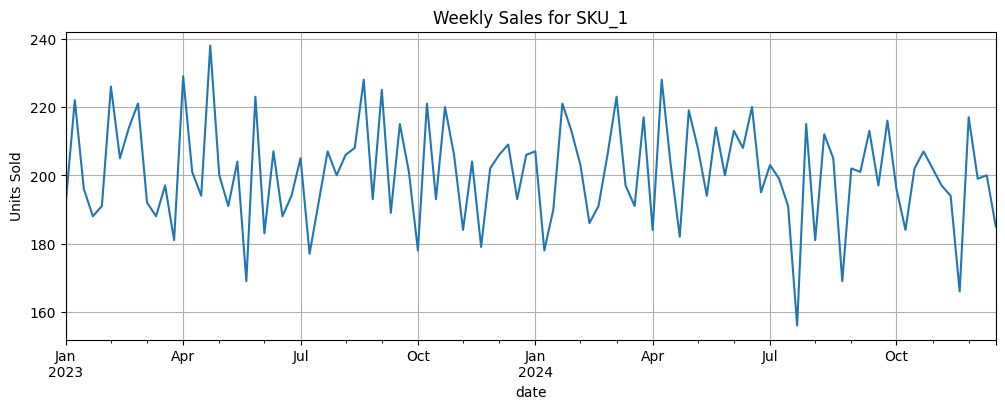

In [2]:
sku_ts.plot(figsize=(12, 4), title='Weekly Sales for SKU_1')
plt.ylabel('Units Sold')
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


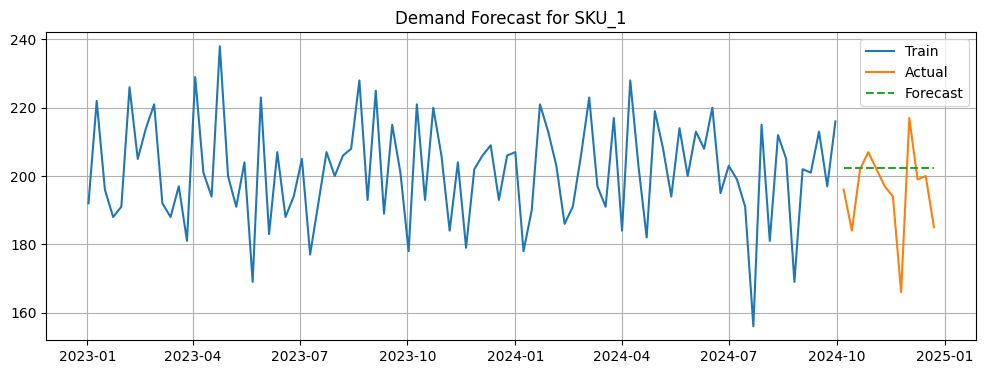

In [3]:
# Train-test split (last 12 weeks for test)
train = sku_ts[:-12]
test = sku_ts[-12:]

# Fit model
model = SimpleExpSmoothing(train).fit(smoothing_level=0.2, optimized=False)
forecast = model.forecast(12)

# Plot actual vs. forecast
plt.figure(figsize=(12, 4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.title('Demand Forecast for SKU_1')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
forecast_df = pd.DataFrame({
    'date': forecast.index,
    'forecast_units': forecast.values,
    'sku_id': 'SKU_1'
})
forecast_df.to_csv('/content/drive/My Drive/sku_1_forecast.csv', index=False)


simple exponential smoothing lags seasonality, no trend handling, consider using more advance forecasting methodology

In [5]:
!pip install prophet


why use prophet because it handles seasonality

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet


In [7]:
from google.colab import drive
drive.mount('/content/drive')

# Load CSV
df = pd.read_csv('/content/drive/My Drive/pharmacy_sales_data.csv', parse_dates=['date'])

# Choose one SKU
sku = 'SKU_1'
sku_df = df[df['sku_id'] == sku].sort_values('date')

# Format for Prophet
prophet_df = sku_df[['date', 'units_sold']].rename(columns={'date': 'ds', 'units_sold': 'y'})


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.fit(prophet_df)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbo0n6ibb/81ao_7ef.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbo0n6ibb/c3ancwty.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35929', 'data', 'file=/tmp/tmpbo0n6ibb/81ao_7ef.json', 'init=/tmp/tmpbo0n6ibb/c3ancwty.json', 'output', 'file=/tmp/tmpbo0n6ibb/prophet_modelitrgnqf0/prophet_model-20250603085612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:56:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:56:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [9]:
# Forecast 12 weeks into the future
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)


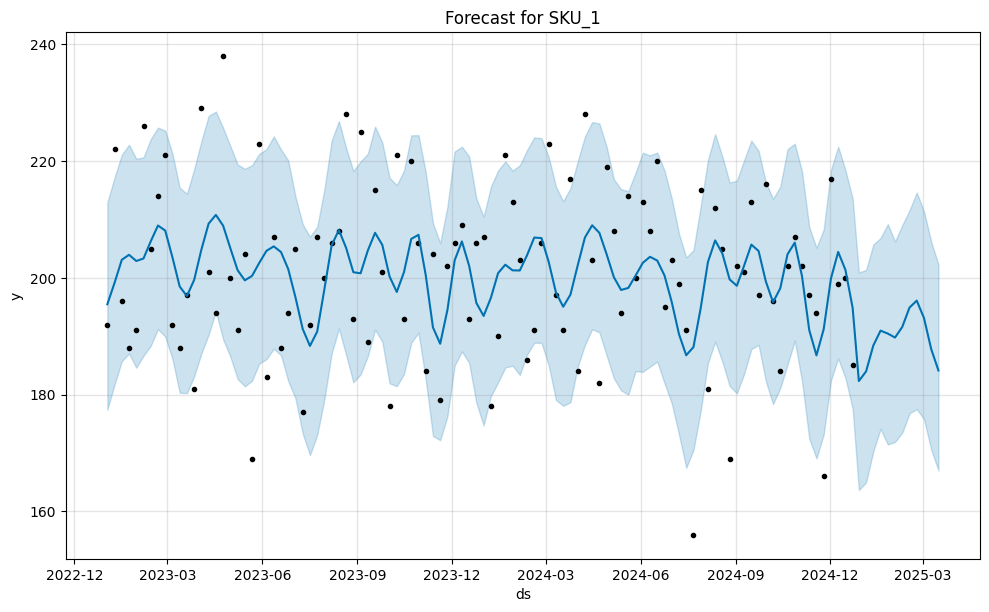

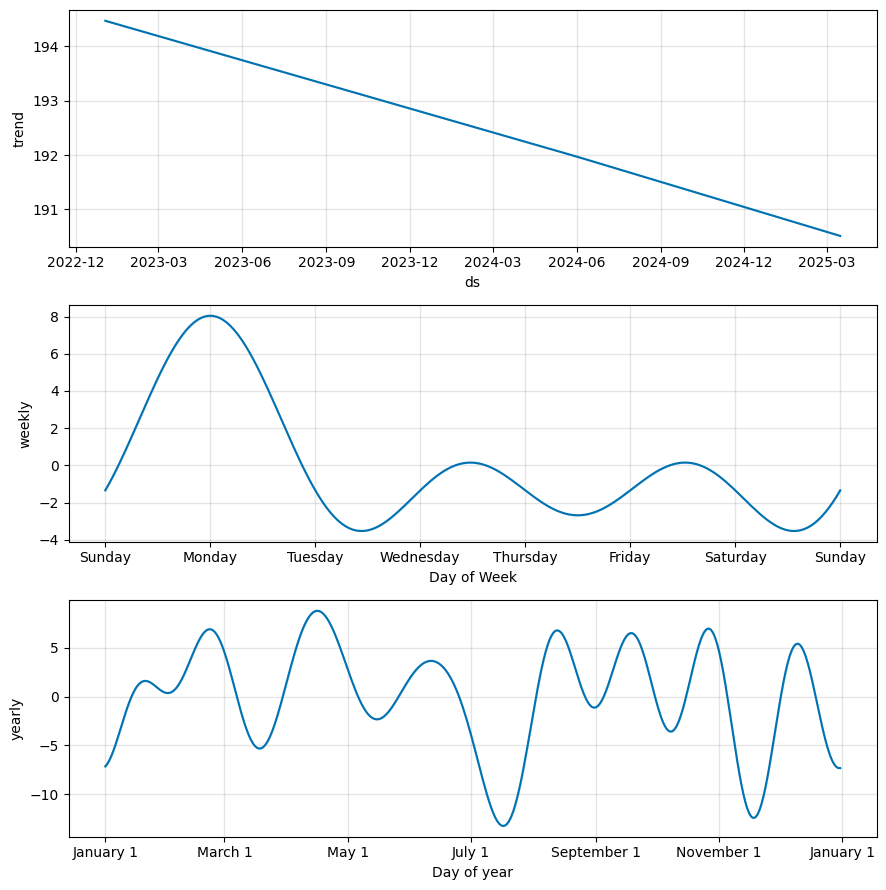

In [10]:
fig1 = model.plot(forecast)
plt.title(f'Forecast for {sku}')
plt.show()

fig2 = model.plot_components(forecast)
plt.show()


In [12]:
forecast_result = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)
forecast_result['sku_id'] = sku
forecast_result.to_csv('/content/drive/My Drive/sku_1_forecast_prophet.csv', index=False)
forecast_result.head()

,ds,yhat,yhat_lower,yhat_upper,sku_id
104,2024-12-29,182.328987,163.650138,200.920400,SKU_1
105,2025-01-05,183.977390,164.973163,201.358184,SKU_1
106,2025-01-12,188.416642,170.294028,205.713915,SKU_1
107,2025-01-19,190.959513,174.132343,206.820332,SKU_1
108,2025-01-26,190.455496,171.462605,209.189840,SKU_1


In [ ]:
skus = df['sku_id'].unique()
for sku in skus[:5]:  # Limit to first 5 SKUs